In [1]:
########################################################################################################
# Versión 1
# Predecir 2020-2021 según modelos ya creados por estación y atributo
# Guarda la prediccion en un archivo
# Guarda la predicción realizada con el formato: Prediccion_20-21_ + COD_ESTACION + ATRIBUTO  ej.: Prediccion_46250048_PM10.csv
########################################################################################################

In [2]:
# Parámetros del algoritmo

# Definir el número de días de la ventana de entrada (días previos a considerar para la predicción)
n = 30

# Definir el número de días a predecir por cada ventana de entrada
ventSalida = 1

# seleccionar lista de atributos a generar modelo de predicción
atributos = ['PM10']

In [3]:
# librerías necesarias

import pandas as pd
import numpy as np
import plotly 
import plotly.express as px
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Input, Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

# Configuración general de las figuras que representaremos
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 10)

import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages

# desactivar modo ansioso de tensorflow
tf.compat.v1.disable_eager_execution()

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
path = '/content/drive/MyDrive/datoscsv/'
dfCompleto = pd.read_csv(path + 'Valencia_SeleccionDatos_ParaModelar_v1.csv', sep=';', index_col='fecha', parse_dates=['fecha'])

# Recuperar la fecha como campo
dfCompleto.insert(0, 'FECHA', dfCompleto.index.strftime('%Y-%m-%d'))


In [6]:
def procesar_atributo(atributo, cod_esta, nom_esta, df):
  print(f'Procesando atributo: {atributo}')
  print()
  
  # Preparación de datos de días previos.
  
  # eliminar filas sin el atributo para probar
  df = df[df[atributo].notnull()]
  # Se toman los "n" ultimos días de 2019 + 2021 y 2021 completos para predecir
  # Para poder introducir los datos en una red neuronal hay que transformarlos, ya que solo funciona con arrays
  df2 = df[[atributo]]
  # print('df2:', df2.describe().transpose())
  train = df2['2019']     # guardar el 2019
  test = train.iloc[-n:]  # guardar los "n" últimos dias del 2019
  test = test.append(df2['2020':'2021'], ignore_index=False) # añadir a los "n" días del 2019 + el 2020 y 2021 completos

  # train[atributo].plot(legend=True)
  # test[atributo].plot(legend=True)
  # plt.legend(['Real (2019)', 'Real (2020)'])
  # plt.title(nom_esta + ': ' + atributo )
  # plt.show()
  
  # Se recupera el modelo guardado previamente:

  pathModelos = '/content/drive/MyDrive/modelosGuardados/'
  modelo = keras.models.load_model(pathModelos + 'Modelo_' + str(cod_esta) + '_' + atributo + '.h5')

  # Predicciones
  # Hay que preparar los datos como en el caso de train, esto es, hacemos bloques de "n" días para realizar la predicción.
  # normalizar datos
  sc = MinMaxScaler(feature_range=(0,1))
  test_scaled = sc.fit_transform(test)

  X_test = []
  for i in range(n,len(test_scaled)):
      X_test.append(test_scaled[i-n:i,0])

  X_test = np.array(X_test)
  X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

  # Realizamos la prediccion y aplicamos normalización inversa para que esté en escala real
  prediccion = modelo.predict(X_test)
  prediccion = sc.inverse_transform(prediccion)

  # Visualización del resultado
  resultados = test.tail(len(test)-n)
  resultados['Prediccion'] = prediccion

  plt.plot(train[atributo], color='green')
  plt.plot(resultados[atributo], color='red', label='Valor real de ' + atributo)
  plt.plot(resultados['Prediccion'], color='blue', label='Predicción de ' + atributo)
  plt.xlabel('Tiempo')
  plt.ylabel('Valor de ' + atributo)
  plt.legend()
  plt.title(nom_esta + ': ' + atributo )
  plt.show()

  from sklearn.metrics import mean_absolute_error
  from sklearn.metrics import mean_squared_error
  from math import sqrt

  # ratios de la predicción
  mae = mean_absolute_error(resultados['Prediccion'], resultados[atributo])
  rmse = sqrt(mean_squared_error(resultados['Prediccion'], resultados[atributo]))

  print(f'Modelo: {cod_esta} - {atributo} / Error cuadrático medio: {rmse:6.3f} / Error absoluto medio: {mae:6.3f}')
  print('========================================')
  print()

  plt.plot(resultados[atributo], color='red', label='Valor real de ' + atributo)
  plt.plot(resultados['Prediccion'], color='blue', label='Predicción de ' + atributo)
  plt.xlabel('Tiempo')
  plt.ylabel('Valor de ' + atributo)
  plt.legend()
  plt.title(nom_esta + ': ' + atributo )
  plt.show()
  
  # Recuperar la fecha como campo en predicción
  resultados.insert(0, 'FECHA', resultados.index.strftime('%Y-%m-%d'))
  print(resultados)
  
  # Guardar la prediccion
  pathPrediccion = '/content/drive/MyDrive/predicciones/'
  (pathModelos + 'Prediccion_' + str(cod_esta) + '_' + atributo + '.csv')
  resultados.to_csv(pathPrediccion + 'Prediccion_2021_' + str(cod_esta) + '_' + atributo + '.csv', header=True, sep=';', index=False)  
    

In [7]:
def procesar_estacion(cod_esta, nom_esta, df):
  print(f'Procesando estacion: {cod_esta} - {nom_esta}')
  print()
  # seleccionar los datos de la estacion a procesar
  df = df[df['COD_ESTACION']==cod_esta]
  # print(df)
  # procesar los atributos de la estación
  for atrib in atributos:
    procesar_atributo(atrib, cod_esta, nom_esta, df)

Procesando estacion: 46250030 - PISTA DE SILLA

Procesando atributo: PM10



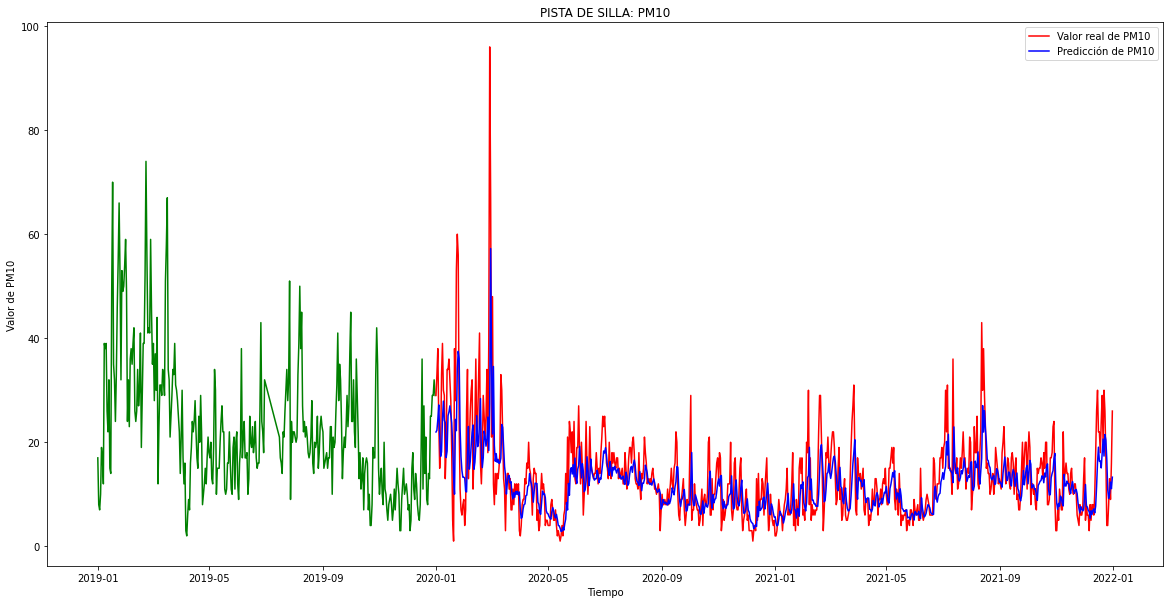

Modelo: 46250030 - PM10 / Error cuadrático medio:  6.468 / Error absoluto medio:  4.249



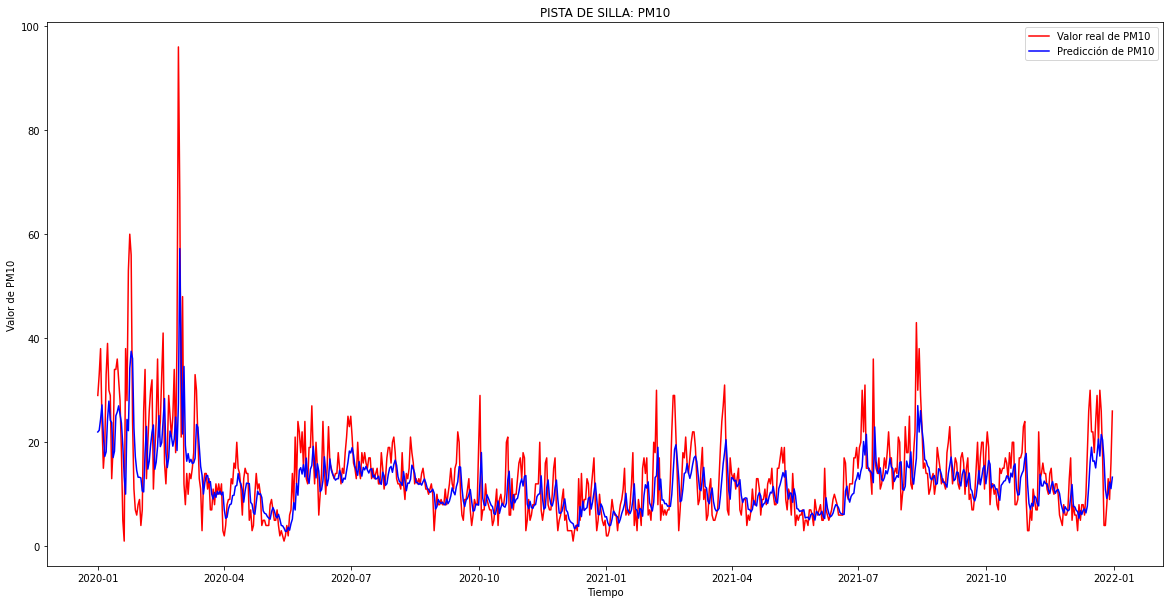

                 FECHA  PM10  Prediccion
fecha                                   
2020-01-01  2020-01-01  29.0   21.973867
2020-01-02  2020-01-02  33.0   22.289984
2020-01-03  2020-01-03  38.0   24.420586
2020-01-04  2020-01-04  24.0   27.177536
2020-01-05  2020-01-05  15.0   21.373280
...                ...   ...         ...
2021-12-27  2021-12-27   8.0    9.200762
2021-12-28  2021-12-28  13.0   10.191413
2021-12-29  2021-12-29   9.0   12.342532
2021-12-30  2021-12-30  16.0   11.074590
2021-12-31  2021-12-31  26.0   13.288187

[731 rows x 3 columns]
Procesando estacion: 46250046 - POLITÈCNIC

Procesando atributo: PM10



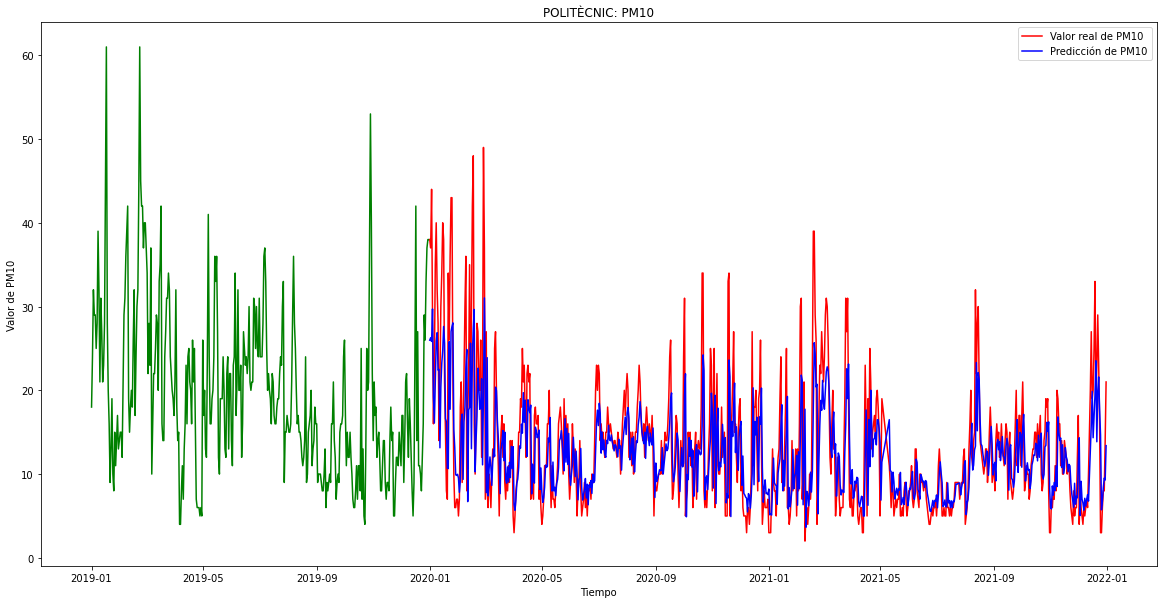

Modelo: 46250046 - PM10 / Error cuadrático medio:  5.767 / Error absoluto medio:  4.013



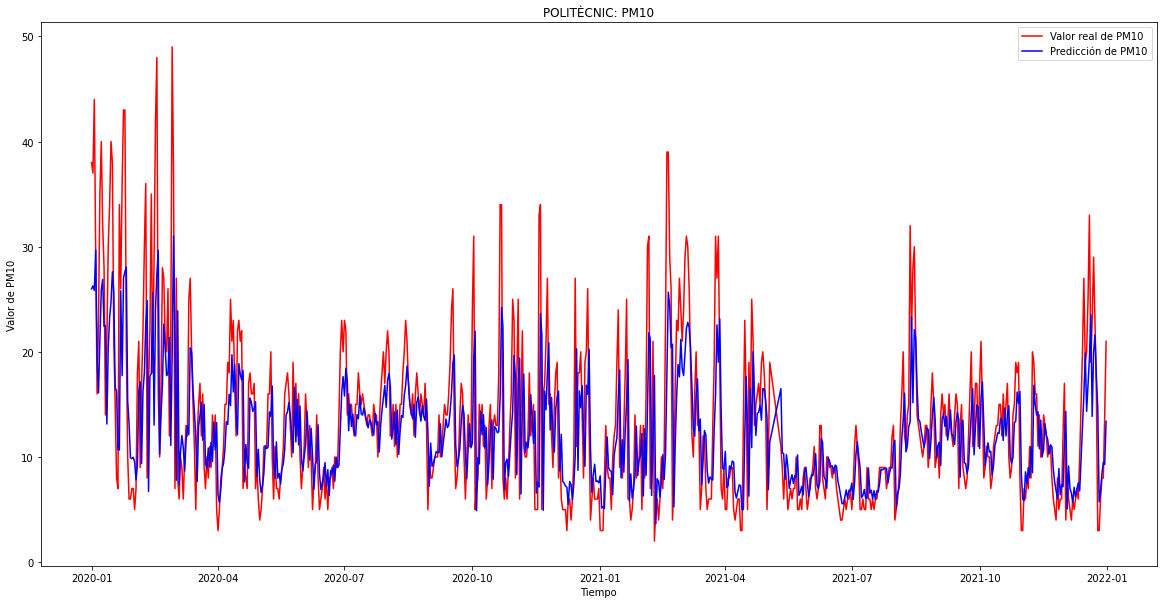

                 FECHA  PM10  Prediccion
fecha                                   
2020-01-01  2020-01-01  38.0   25.986727
2020-01-02  2020-01-02  37.0   26.274469
2020-01-03  2020-01-03  44.0   25.835812
2020-01-04  2020-01-04  29.0   29.713419
2020-01-05  2020-01-05  16.0   19.241415
...                ...   ...         ...
2021-12-27  2021-12-27   6.0    6.794554
2021-12-28  2021-12-28   8.0    8.393343
2021-12-29  2021-12-29   8.0    9.511035
2021-12-30  2021-12-30  14.0    9.288168
2021-12-31  2021-12-31  21.0   13.395724

[723 rows x 3 columns]
Procesando estacion: 46250047 - AVD. FRANCIA

Procesando atributo: PM10



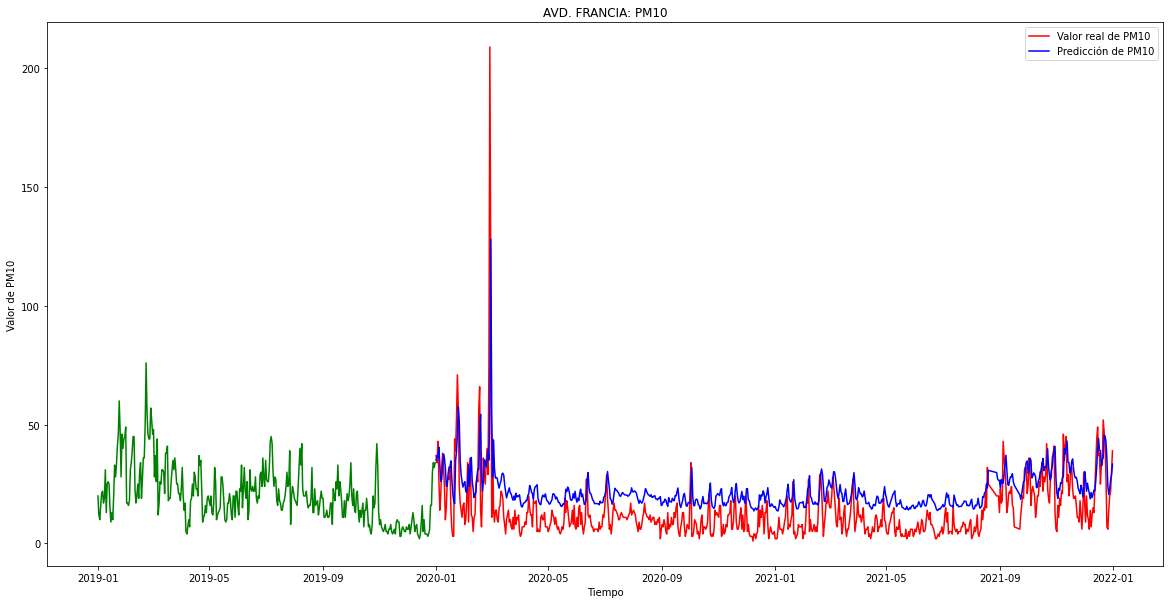

Modelo: 46250047 - PM10 / Error cuadrático medio: 12.607 / Error absoluto medio: 10.111



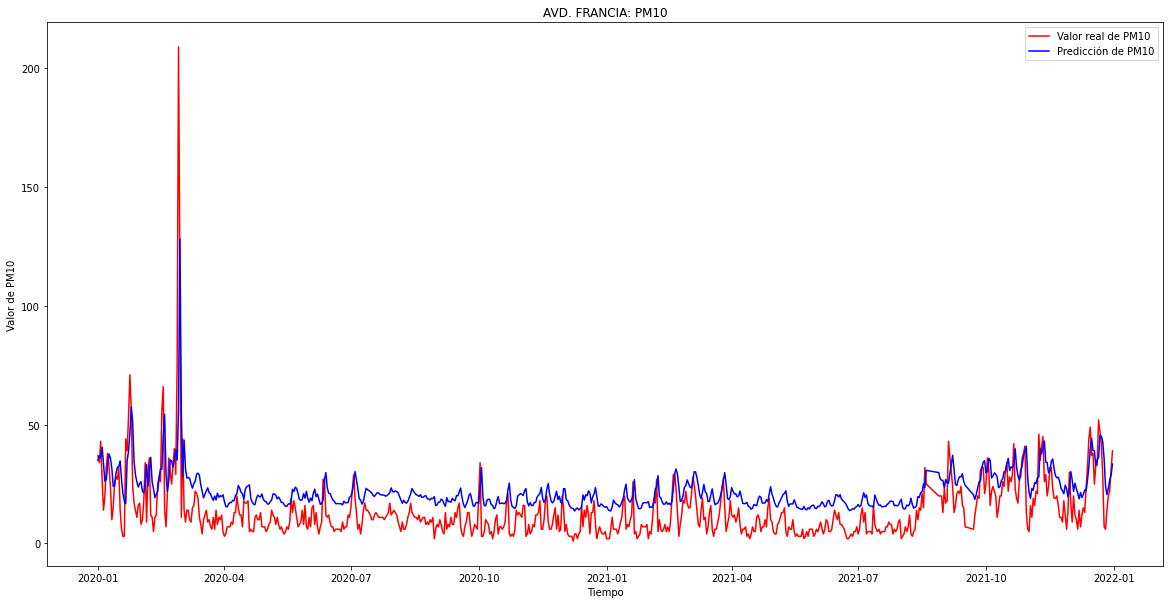

                 FECHA  PM10  Prediccion
fecha                                   
2020-01-01  2020-01-01  37.0   35.000191
2020-01-02  2020-01-02  34.0   36.925224
2020-01-03  2020-01-03  43.0   36.076614
2020-01-04  2020-01-04  27.0   40.504974
2020-01-05  2020-01-05  14.0   33.619980
...                ...   ...         ...
2021-12-27  2021-12-27  14.0   20.553291
2021-12-28  2021-12-28  20.0   23.059448
2021-12-29  2021-12-29  22.0   26.750731
2021-12-30  2021-12-30  31.0   28.762739
2021-12-31  2021-12-31  39.0   33.425426

[716 rows x 3 columns]
Procesando estacion: 46250048 - MOLÍ DEL SOL

Procesando atributo: PM10



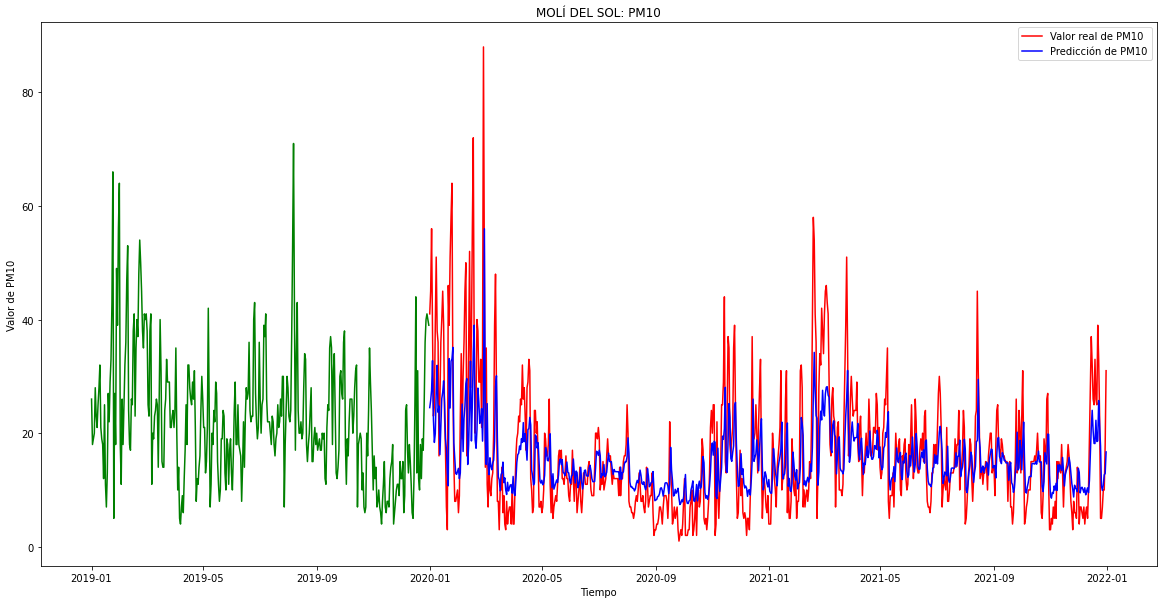

Modelo: 46250048 - PM10 / Error cuadrático medio:  8.020 / Error absoluto medio:  5.566



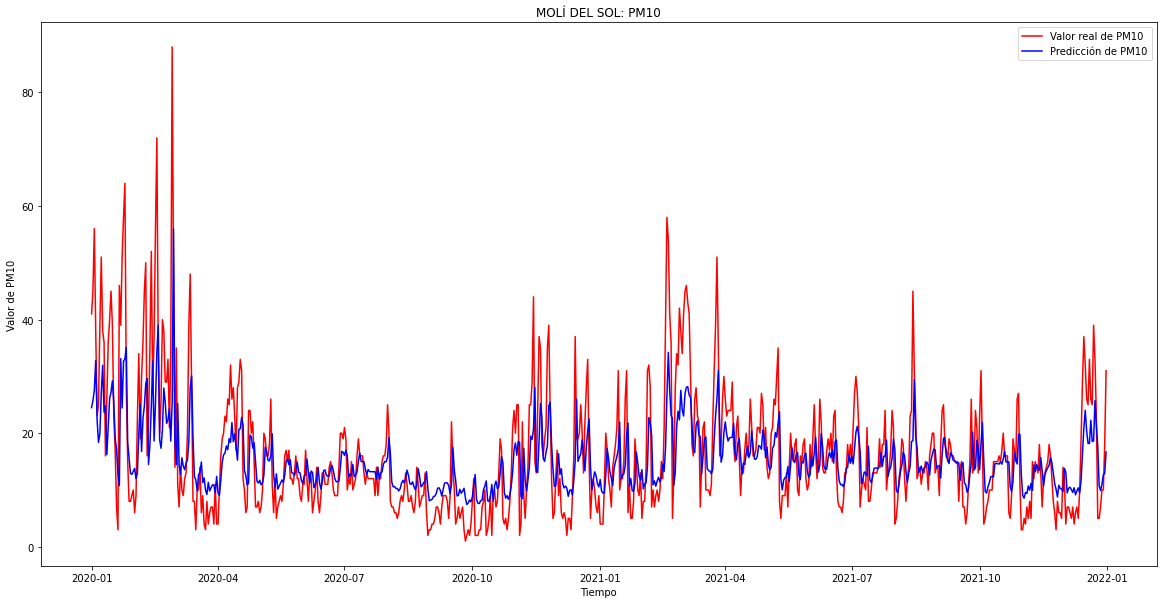

                 FECHA  PM10  Prediccion
fecha                                   
2020-01-01  2020-01-01  41.0   24.499079
2020-01-02  2020-01-02  45.0   25.736996
2020-01-03  2020-01-03  56.0   27.582508
2020-01-04  2020-01-04  38.0   32.772484
2020-01-05  2020-01-05  23.0   22.297253
...                ...   ...         ...
2021-12-27  2021-12-27   7.0    9.915446
2021-12-28  2021-12-28  10.0   10.951992
2021-12-29  2021-12-29  10.0   12.666280
2021-12-30  2021-12-30  18.0   12.903049
2021-12-31  2021-12-31  31.0   16.697596

[731 rows x 3 columns]


In [8]:
# Proceso principal

# print(dfCompleto['COD_ESTACION'].unique())
# print(dfCompleto['NOM_ESTACION'].unique())
cod_estaciones = dfCompleto['COD_ESTACION'].unique()
nom_estaciones = dfCompleto['NOM_ESTACION'].unique()
for cod_esta, nom_esta in zip(cod_estaciones, nom_estaciones):
  procesar_estacion(cod_esta, nom_esta, dfCompleto)